In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql
import importlib
from brokenaxes import brokenaxes

sys.path.append("..")
import analysislib as alib
importlib.reload(alib)

# ABOVE ZNONEOFTHE

sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12})

In [3]:
df_aha = pd.read_csv("../../data/2025-10-21-time-17-01-56-jvmheap-compression/zram_consolidated.csv")

In [4]:
df_aha.columns

Index(['benchmark', 'device', 'AVG_COMPR_SIZE_MB', 'AVG_DATA_SIZE_MB',
       'AVG_HUGE_PAGES', 'AVG_INCOMPRESSIBLE_DATA_MB', 'AVG_RATIO',
       'AVG_SAME_PAGES', 'HUGE_PAGES_AT_MAX_DATA_SIZE',
       'INITIAL_ENTRIES_SKIPPED', 'MAX_COMPR_SIZE_MB', 'MAX_DATA_SIZE_MB',
       'MAX_HUGE_PAGES', 'MAX_SAME_PAGES', 'RATIO_AT_MAX_DATA_SIZE',
       'RATIO_STDDEV', 'SAME_PAGES_AT_MAX_DATA_SIZE',
       'STARTUP_ENTRIES_SKIPPED'],
      dtype='object')

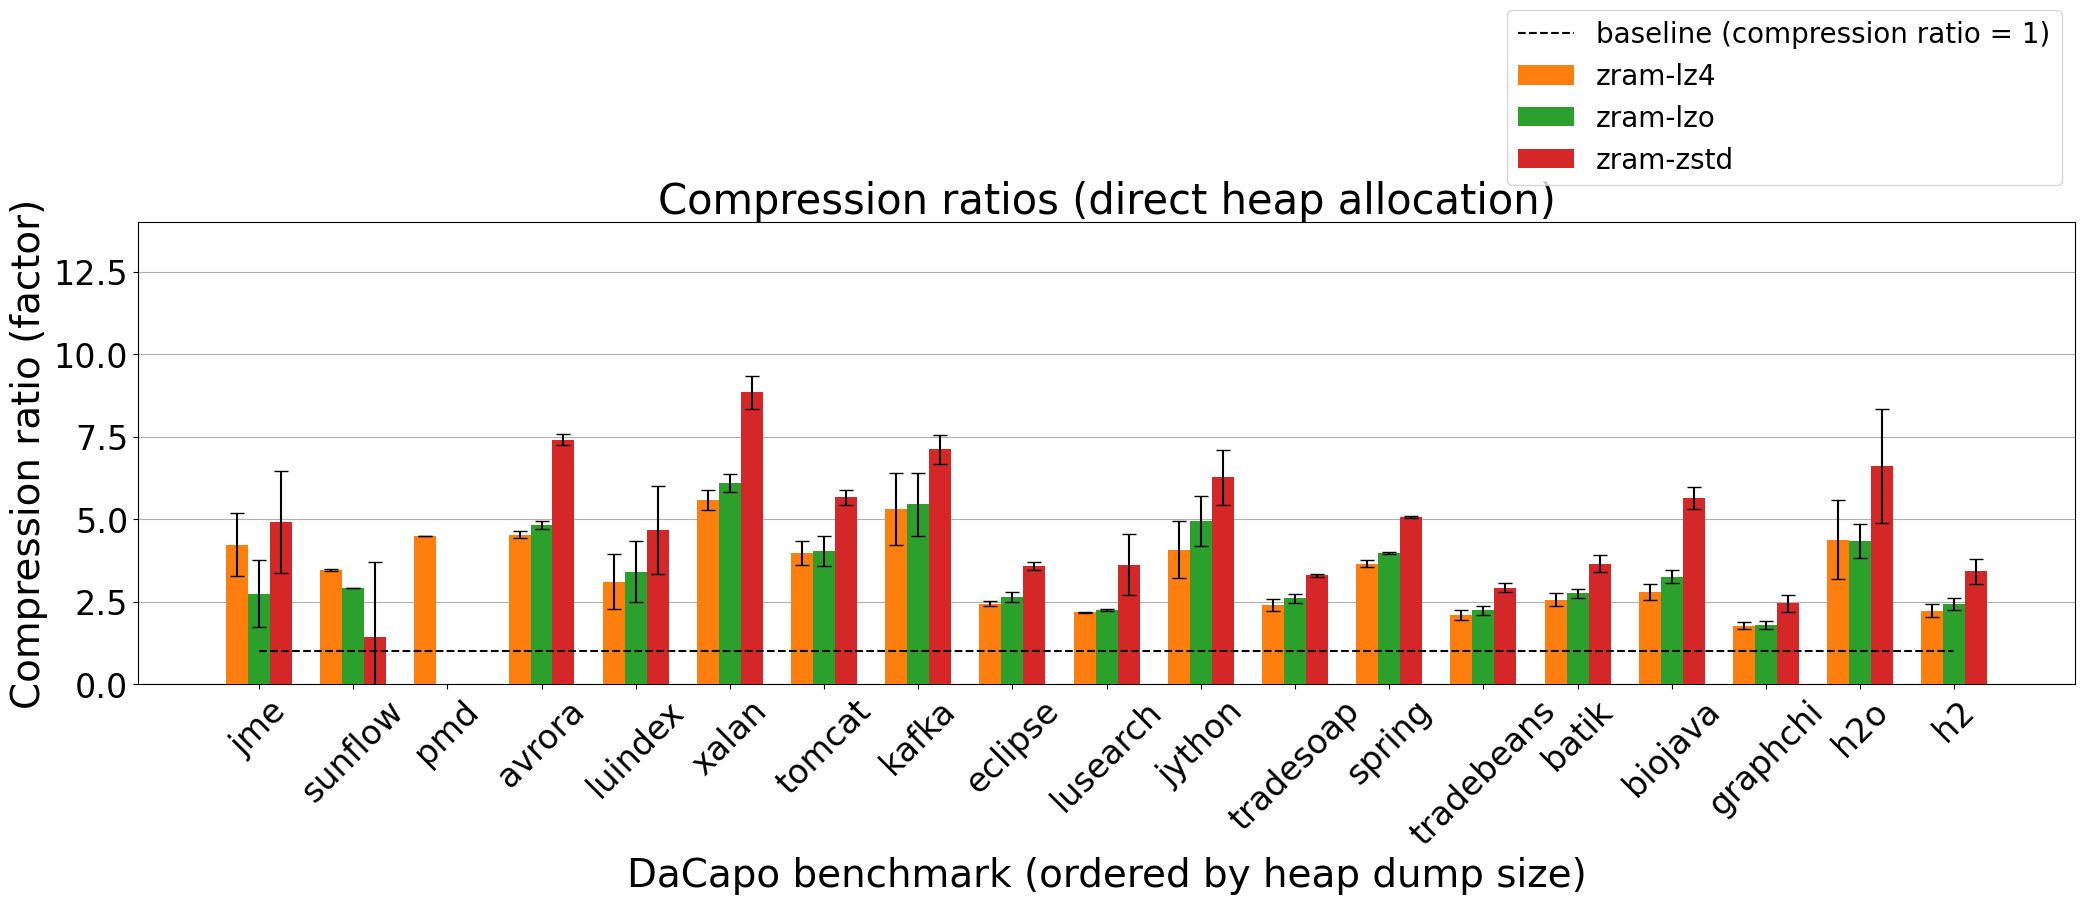

In [5]:
# Get benchmarks ordered by their average data size
benchmarks_ordered = sqflat("""
    SELECT benchmark 
    FROM df_aha 
    GROUP BY benchmark 
    ORDER BY AVG(AVG_DATA_SIZE_MB)
""")

alib.grouped_barplot(
    df=df_aha,
    grouping_col="device",
    config_col="benchmark", 
    value_col="AVG_RATIO",
    error_col="RATIO_STDDEV",
    config_order=benchmarks_ordered, 
    grouping_order=["zram2", "zram0", "zram1"], 
    figsize=[25, 6],
    labels=["zram-lz4", "zram-lzo", "zram-zstd"],
    xlabel="DaCapo benchmark (ordered by heap dump size)",
    ylabel="Compression ratio (factor)",
    colors=["#ff7f0e", "#2ca02c", "#d62728"],
    show=False
)

nb = len(benchmarks_ordered)
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.ylim([0, 14])

plt.gca().get_yaxis().label.set_fontsize(28)
plt.gca().get_xaxis().label.set_fontsize(28)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
plt.xticks(rotation=45)

plt.legend(fontsize=20, bbox_to_anchor=(1, 1.05), loc="lower right")

plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-allocateheapat.png", bbox_inches="tight")
plt.title("Compression ratios (direct heap allocation)")
plt.gca().title.set_fontsize(30)
plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-allocateheapat-w-title.png", bbox_inches="tight")
plt.show()

In [6]:
print(sq("SELECT device, benchmark, AVG_RATIO FROM df_aha ORDER BY device, benchmark"))

   device   benchmark  AVG_RATIO
0   zram0      avrora       4.83
1   zram0       batik       2.76
2   zram0     biojava       3.26
3   zram0     eclipse       2.64
4   zram0    graphchi       1.81
5   zram0          h2       2.43
6   zram0         h2o       4.35
7   zram0         jme       2.75
8   zram0      jython       4.96
9   zram0       kafka       5.46
10  zram0     luindex       3.41
11  zram0    lusearch       2.26
12  zram0         pmd        NaN
13  zram0      spring       3.97
14  zram0     sunflow       2.93
15  zram0      tomcat       4.05
16  zram0  tradebeans       2.25
17  zram0   tradesoap       2.61
18  zram0       xalan       6.10
19  zram1      avrora       7.42
20  zram1       batik       3.66
21  zram1     biojava       5.64
22  zram1     eclipse       3.59
23  zram1    graphchi       2.46
24  zram1          h2       3.43
25  zram1         h2o       6.63
26  zram1         jme       4.91
27  zram1      jython       6.27
28  zram1       kafka       7.12
29  zram1 

In [7]:
sq("SELECT device, AVG(AVG_RATIO) from df_aha GROUP BY device")

,device,AVG(AVG_RATIO)
0,zram0,3.490556
1,zram1,4.817778
2,zram2,3.441579


# dumpy 

In [8]:
df_dumps = pd.read_csv("../../data/2025-10-22-time-22-35-51-dump-compression/zram_consolidated.csv")

In [9]:
df_dumps.columns

Index(['benchmark', 'dump_number', 'device', 'AVG_COMPR_SIZE_MB',
       'AVG_DATA_SIZE_MB', 'AVG_HUGE_PAGES', 'AVG_INCOMPRESSIBLE_DATA_MB',
       'AVG_RATIO', 'AVG_SAME_PAGES', 'HUGE_PAGES_AT_MAX_DATA_SIZE',
       'INITIAL_ENTRIES_SKIPPED', 'MAX_COMPR_SIZE_MB', 'MAX_DATA_SIZE_MB',
       'MAX_HUGE_PAGES', 'MAX_SAME_PAGES', 'RATIO_AT_MAX_DATA_SIZE',
       'RATIO_STDDEV', 'SAME_PAGES_AT_MAX_DATA_SIZE',
       'STARTUP_ENTRIES_SKIPPED'],
      dtype='object')

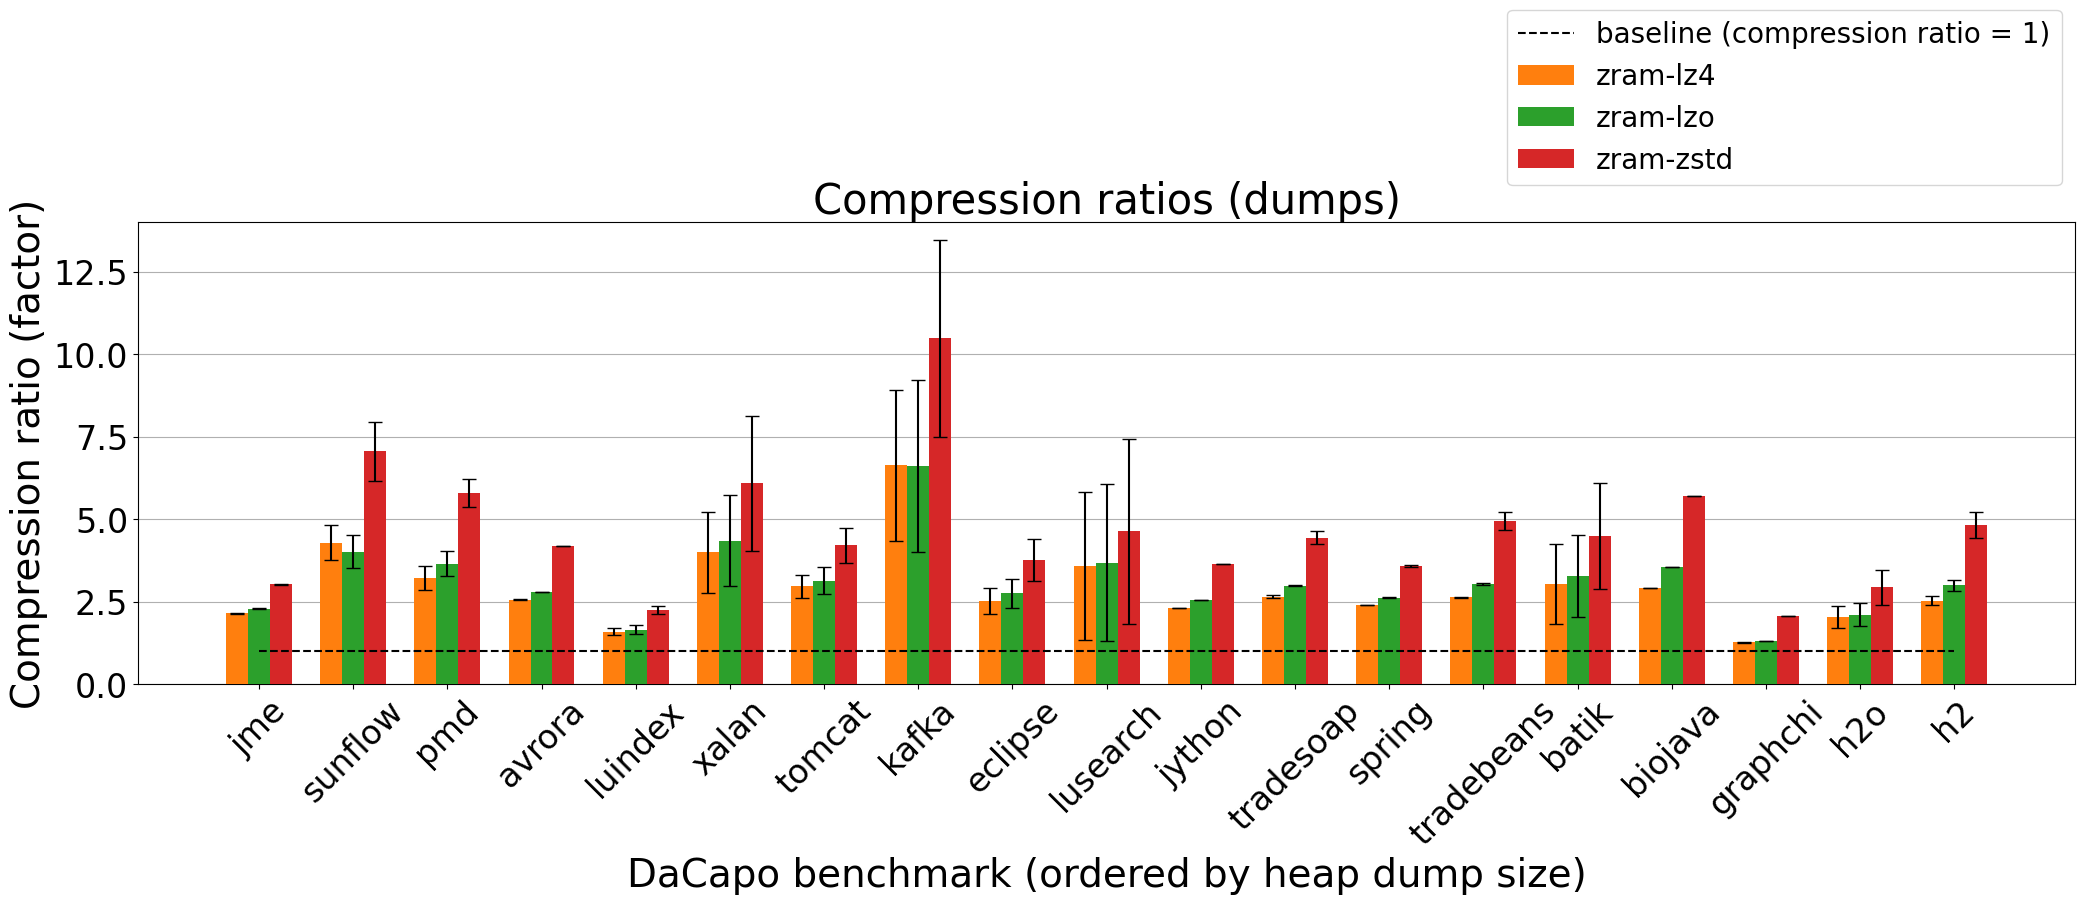

In [10]:
# Calculate aggregated data with pandas instead of SQL
df_agg = df_dumps.groupby(['benchmark', 'device'])['AVG_RATIO'].agg(['mean', 'std']).reset_index()
df_agg.columns = ['benchmark', 'device', 'ratio', 'err']

alib.grouped_barplot(
    df=df_agg,
    grouping_col="device",
    config_col="benchmark",
    value_col="ratio",
    error_col="err",
    config_order=benchmarks_ordered, 
    grouping_order=["zram2", "zram0", "zram1"], 
    figsize=[25, 6],
    labels=["zram-lz4", "zram-lzo", "zram-zstd"],
    xlabel="DaCapo benchmark (ordered by heap dump size)",
    ylabel="Compression ratio (factor)",
    colors=["#ff7f0e", "#2ca02c", "#d62728"],
    show=False
)

nb = len(benchmarks_ordered)
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.ylim([0, 14])

plt.gca().get_yaxis().label.set_fontsize(28)
plt.gca().get_xaxis().label.set_fontsize(28)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
plt.xticks(rotation=45)

plt.legend(fontsize=20, bbox_to_anchor=(1, 1.05), loc="lower right")

plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios.png", bbox_inches="tight")
plt.title("Compression ratios (dumps)")
plt.gca().title.set_fontsize(30)
plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-w-title.png", bbox_inches="tight")
plt.show()


In [16]:
sq("""SELECT * 
      FROM (SELECT device, AVG(AVG_RATIO) AS ratio_dumps from df_dumps GROUP BY device)
            NATURAL JOIN (SELECT device, AVG(AVG_RATIO) AS ratio_direct FROM df_aha GROUP BY device)""")

,device,ratio_dumps,ratio_direct
0,zram0,3.067093,3.490556
1,zram1,4.511744,4.817778
2,zram2,2.841977,3.441579


In [12]:
sq("""SELECT * 
     FROM (SELECT benchmark, AVG(AVG_DATA_SIZE_MB) AS size_hprof from df_dumps GROUP BY benchmark) 
          NATURAL JOIN (SELECT benchmark, AVG(AVG_DATA_SIZE_MB) AS size_direct FROM df_aha GROUP BY benchmark)
     ORDER BY size_direct""")

,benchmark,size_hprof,size_direct
0,jme,12.850000,59.850000
1,sunflow,196.105000,93.653333
2,pmd,5141.070000,120.000000
3,avrora,24.506000,133.456667
4,luindex,17.592000,764.746667
5,xalan,39.832500,1047.543333
6,tomcat,53.266667,1207.343333
7,kafka,305.176000,1210.540000
8,eclipse,61.528000,1226.766667
9,lusearch,76.608000,1661.540000
